# Dimensionality reduction using Autoencoder

## Modules

In [19]:
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch.optim as optim
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import statistics
from sklearn.metrics import mean_squared_error
import models

### Device for training

In [4]:
# Define GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Train data

In [5]:
#loading training dataset

train_data = np.load("Data/Ferguson_fire_train.npy")
train_size = train_data.shape[0]
train_width = train_data.shape[1]
train_height = train_data.shape[2]
train_channels = 1
#Reshaping the dataset to create( batch_size, channel, height, width) shape for dataset.
train_data = train_data.reshape(train_size, train_channels, train_width, train_height)
print(f"After reshaping: {train_data.shape}")
print("Data type of train array: ", train_data.dtype)
print("Shape of train data: ", train_data.shape)
print("Unique pixel values in train data: ", np.unique(train_data))

After reshaping: (12500, 1, 256, 256)
Data type of train array:  int16
Shape of train data:  (12500, 1, 256, 256)
Unique pixel values in train data:  [0 1]


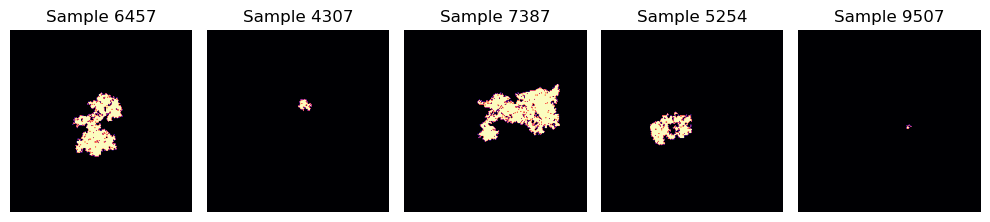

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(10, 8))

axes = axes.ravel() 
for i in range(5):
    sample = np.random.randint(0, 12500)
    axes[i].imshow(train_data[sample].reshape(256, 256), extent=[0, 10, 0, 10], cmap='magma') 
    axes[i].set_title(f"Sample {sample}") 
    axes[i].set_axis_off()
plt.tight_layout()
plt.show()

## Creating a dataset

In [7]:
#Creating a custom dataset using torch.utils.data module

class CustomDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = torch.from_numpy(data).float() # Convert to tensor
        
    def __getitem__(self, index):
        x = self.data[index]
        return x
    
    def __len__(self):
        return len(self.data)
    
batch_size = 50 #Number of batches
dataset = CustomDataset(train_data)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

## Original vs denoised images

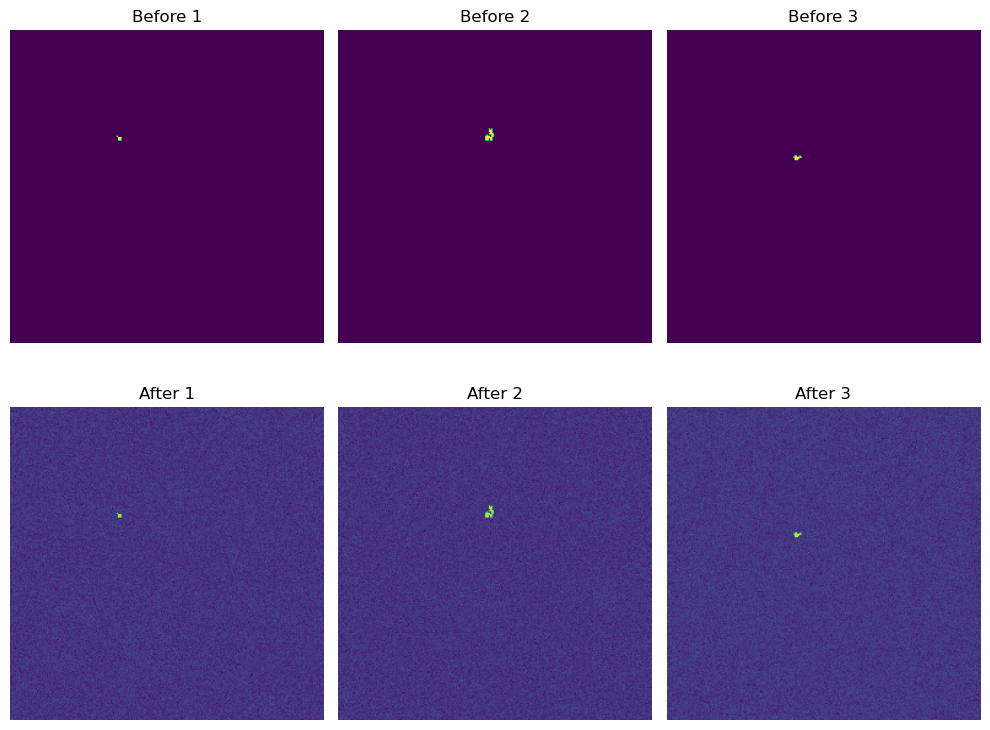

In [8]:
sigma = 0.05

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 8))
axes = axes.ravel() 
for i in range(3):
    data = train_data[np.random.randint(0, 5000)] 
    axes[i].imshow(data.reshape(256, 256), extent=[0, 10, 0, 10]) 
    axes[i].set_title(f"Before {i+1}") 
    axes[i].set_axis_off()
    
    noise = np.random.normal(loc=0, scale=sigma, size=data.shape)
    data = data + noise

    axes[i+3].imshow(data.reshape(256, 256), extent=[0, 10, 0, 10]) 
    axes[i+3].set_title(f"After {i+1}") 
    axes[i+3].set_axis_off()
plt.tight_layout() 
plt.show()

## Defining a function for training

In [9]:
def train_denoise_convolutional(model=None, loss_func=None, dataloader=None, learning_rate=0.0004, num_epochs=10, device=None):
    """
    Trains convolutional model
    
    Parameters
    ----------
        model: torch.nn convolutional model
        loss_func: loss function for the model
        dataloader: torch.utils.data.dataloader object to create batches while training
        learning_rate: gradient descent rate
        num_epochs: Number of epochs to train the model for
        device: Device used for training
    """
    #Optimiser used for this model. Went for Adam because it is popular and recommended.
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    losses = []
    sigma = 0.05  # Noise ratio

    for epoch in range(num_epochs):
        running_loss = []
        for i, data in enumerate(dataloader):
            input = data
#             noise = torch.randn_like(input) * sigma
#             input = input + noise
            if (device):
                #Sending data to GPU if available
                inputs = input.to(device)
            else:
                inputs = input
            # clearing the gradients from before
            optimizer.zero_grad()
            # Forward pass to the model
            outputs = model(inputs)
            # Loss calculation
            loss = loss_func(outputs, inputs)
            # Back propagation
            loss.backward()
            # Optimise 
            optimizer.step()
            running_loss.append(loss.item())
        
        epoch_loss = statistics.mean(running_loss)
        losses.append(epoch_loss)
        print("Epoch: ", epoch+1, "/", num_epochs, "Loss: ", epoch_loss)

    # Plot epoch vs. loss
    plt.plot(range(1, num_epochs+1), losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Epoch vs. Loss')
    plt.show()

    return losses


##  Importing function to instantiate models

In [ ]:
# Selecting the 2nd model from model.py. Since, it is the current best model. With 100 latent space dimensions
model, loss_function = models.select_model(type=2, latent_dim=100)

if (device != 'cpu'):
    model = model.float().to(device) #IF working with CUDA GPU
else:
    model = model.float()

# Print the model architecture
print(model)

## Training the model

In [22]:
epochs = 30

In [ ]:

losses = train_denoise_convolutional(model=model, loss_func=loss_function, dataloader=dataloader, num_epochs=epochs, device=device)

## Image after reconstruction

In [ ]:
#Displaying the image before and after model orward pass

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 8)) 
axes = axes.ravel()
original_data = train_data[5898: 5901]
if (device):
    model_data = model(torch.from_numpy(original_data).float().to(device)).detach().cpu().numpy() #for GPU device
else:
    model_data = model(torch.from_numpy(original_data).float()).detach().numpy() #For CPU device 
print(original_data.shape, model_data.shape)

for i in range(3):

    axes[i].imshow(original_data[i].reshape(256, 256), extent=[0, 10, 0, 10], cmap='magma') 
    axes[i].set_title(f"Before {i+1}") 
    axes[i].set_axis_off()

    axes[i+3].imshow(model_data[i].reshape(256, 256), extent=[0, 10, 0, 10], cmap='magma') 
    axes[i+3].set_title(f"After {i+1}") 
    axes[i+3].set_axis_off() 
plt.tight_layout() 
plt.show() 

## Saving the model

In [ ]:
save_path = 'convolutional_20.pth'

# Save the model
torch.save(model.state_dict(), save_path)
#Clearning the cache to free up GPU
torch.cuda.empty_cache()

## Loading the model

In [13]:
# It is necessary to create the same Neural Network as the saved model
model, _ = models.select_model(type=2, latent_dim=100)#loading the model on CPU
# model = model.to(device)
# Loading the weights from saved model
model.load_state_dict(torch.load('convolutional_20.pth'))

<All keys matched successfully>

In [14]:
# Calculating the number of hidden network layers\

l = [module for module in model.modules() if not isinstance(module, nn.Sequential)]
hidden_layers = len(l[1:])

# Test data

In [15]:
#Loading test dataset

test_data = np.load("Data/Ferguson_fire_test.npy")
test_size = test_data.shape[0]
test_width = test_data.shape[1]
test_height = test_data.shape[2]
test_channels = 1
#Reshaping the dataset to create( batch_size, channel, height, width) shape for dataset.
test_data = test_data.reshape(test_size, test_channels, test_width, test_height)
print("Data type: ", test_data.dtype)
print("Shape: ", test_data.shape)
print("Unique pixel values: ", np.unique(test_data))
print("Batch size: ", test_size)
print("Width: ", test_width)
print("Height ", test_height)

Data type:  int16
Shape:  (5000, 1, 256, 256)
Unique pixel values:  [0 1]
Batch size:  5000
Width:  256
Height  256


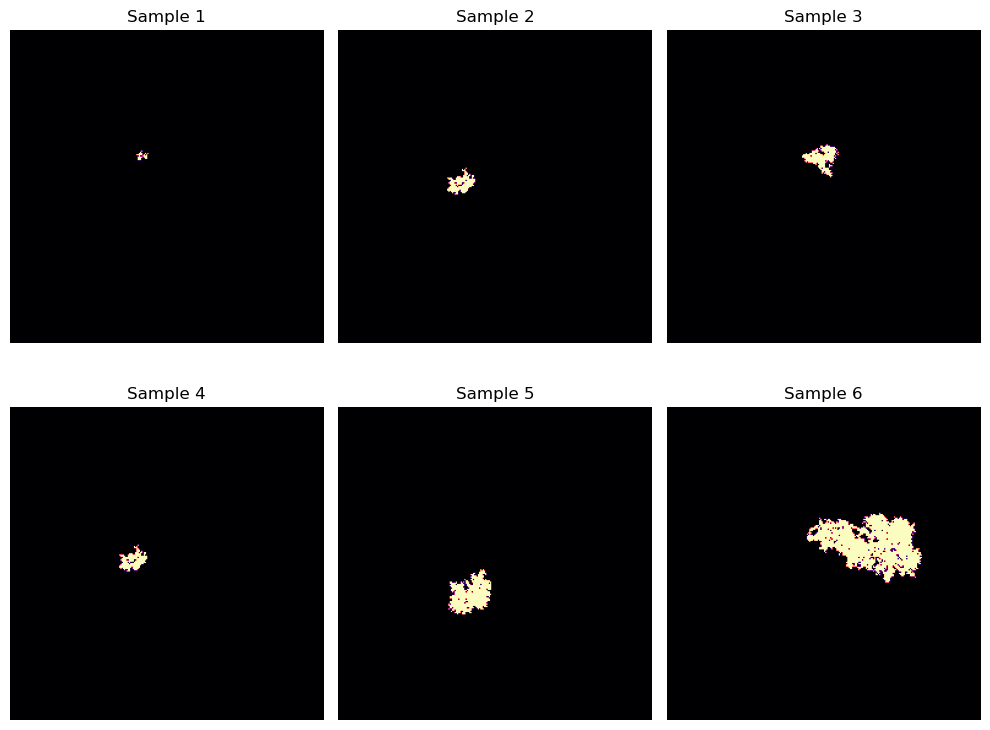

In [16]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 8))
axes = axes.ravel() 
for i in range(6):
    data = test_data[np.random.randint(0, 5000)] 
    axes[i].imshow(data.reshape(256, 256), extent=[0, 10, 0, 10], cmap='magma') 
    axes[i].set_title(f"Sample {i+1}") 
    axes[i].set_axis_off()
plt.tight_layout() 
plt.show()

## MSE calculation

In [24]:
# MSE is calculated in batches to avoid memory RunTimeError.
start = time.time()
mse = 0
for i in range(10):
    data = test_data[i*500: (i+1)*500]
    model_data =  model(torch.from_numpy(data).float()).detach().numpy()
    mse += mean_squared_error(data.flatten(), model_data.flatten())
mse = mse/10
end = time.time()
time_taken = end - start

## Results

In [25]:
print("Epochs: ", epochs)
print("Hidden layers", hidden_layers)
print("MSE after decompression: ", mse)
print("Execution time: ", time_taken)

Epochs:  30
Hidden layers 22
MSE after decompression:  0.007636270555667579
Execution time:  16.28362464904785


## Analysis:

- Neural network based autoencoders can capture non-linear relationships in the data.
- Different models were developed in `models.py`.
   - ConvolutionAE1 with `even number kernel_size and stride` in decoder gave checkered board artifacts.
   - ConvolutionAE2 with `odd number kernel_size and stride along with upsampling` helped improve the results.
   - Using a Variational encoder did not give better results. Maybe I had problems with reparametrisation.
- Encoder half
  - <b>`Denoising did not give better results than training with original images.`</b>. 
  - Encoder down-sampling occurs via strided-convolution rather than max pooling so that the network can learn its own sub-sampling routine [1].
  - Encoder and decoder layers are mirrored to reduce the design space size.
  - For reguarisation denosing was tried. According to [1] dropout harmed performance, even when it was applied channel-wise, and only to latter layers. 
  -  Convolutions have kernel size k = 3 or less to reduce the number of parameters and computational cost.
  - Avoiding addition of padding in later encoder layers as these can introduce artefacts in the reconstructed state[1].
  - Batch Normalisation is not used in the down-sampling backbone of the CAE architectures because our preliminary investigation showed that it resulted in reconstructions of considerably poorer quality[1]
- Decoder half
  - I got `checkered board artifacts` in output images. I was able to solved this problem with `odd values of stride` and `kernel size in transposed convolution`. Also, using` Upsampling techniques with mode=bilinear` helped. 
![Checkered](img/checkered.png)
  
  <b>Reference: [1] [Attention-based Convolutional Autoencoders for 3D-Variational Data Assimilation](https://arxiv.org/abs/2101.02121)</b>